# Plot Brightness Temperature Data Overview as Matrix

This notebook reads observed and synthetic brightness temperature (BT) data (from disk) for a certain time and make some (hopefully) nice overview plots.

## Libs

In [1]:
%matplotlib inline

import os, sys, glob, copy
import numpy as np
import pylab as pl
import datetime
import scipy.ndimage
import pandas as pd
import xarray as xr
#import seaborn as sns


import nawdex_analysis.io.input_lev2 as input_lev2
import nawdex_analysis.io.selector
import nawdex_analysis.plot.nawdex_map



In [2]:

pl.rcParams['figure.figsize'] = (16.0, 12.0)
pl.rcParams['font.size'] = 16.0


## A subsampling function for speed

In [3]:
def subsamp2d( d, nsub = 4 ):
    
    dsub = {}
    for k in d.keys():
        
        v = d[k]

        try:
            if np.ndim(v) == 2:
                vsub = v[::nsub, ::nsub]
        except:
            vsub = v
            print '%s not an 2d array?' % k
            
        dsub[k] = vsub
        
    return dsub
        

## Plot of BTs

### Input Data

In [5]:
time = datetime.datetime(2016,9,24, 12, 0)
time = datetime.datetime(2016,9,23, 12, 0)


In [6]:
flist = nawdex_analysis.io.selector.make_filetime_index('bt108', time, subdirs=['meteosat', 'synsat'])

sorted( flist )

[datetime.datetime(2016, 9, 23, 12, 0)]

In [7]:
b108stack = {}
b062stack = {}

for fname in flist[time]:
    if 'mis-0001' in fname or 'msevi' in fname:
        basename = os.path.basename( fname )
        b108stack[basename] = input_lev2.read_data_field( fname, time, 'bt108')
        b062stack[basename] = input_lev2.read_data_field( fname, time, 'bt062')


.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/sen

In [8]:
for basename in sorted( b108stack ):
    if 'synsat' in basename:
        expname = basename.replace('synsat-', '').replace('.nc', '')
        
        print expname, nawdex_analysis.io.selector.expname2conf_str( expname )

nawdexnwp-10km-mis-0001 10km_oneMom_Conv
nawdexnwp-20km-mis-0001 20km_oneMom_Conv
nawdexnwp-2km-mis-0001-shcon 2km_oneMom_shConv
nawdexnwp-2km-mis-0001 2km_oneMom_noConv
nawdexnwp-40km-mis-0001 40km_oneMom_Conv
nawdexnwp-5km-mis-0001 5km_oneMom_Conv
nawdexnwp-80km-mis-0001 80km_oneMom_Conv


In [9]:
ilist = [0, 4, 6, 1, 2, 5, 7 ]
sorted_fnames = np.array(sorted( b108stack ))[ilist]
sorted_fnames

array(['msevi-nawdex-20160923.nc', 'synsat-nawdexnwp-2km-mis-0001.nc',
       'synsat-nawdexnwp-5km-mis-0001.nc',
       'synsat-nawdexnwp-10km-mis-0001.nc',
       'synsat-nawdexnwp-20km-mis-0001.nc',
       'synsat-nawdexnwp-40km-mis-0001.nc',
       'synsat-nawdexnwp-80km-mis-0001.nc'], dtype='|S38')

### Subsampling

In [10]:
if False:
#if True:
    for fname in sorted_fnames:
        b108stack[fname] = subsamp2d( b108stack[fname], nsub = 6 )
        b062stack[fname] = subsamp2d( b062stack[fname], nsub = 6 )
    

## Solve Issues with NaN Georef Values

`pcolormesh` does not allow for NaNs in the georef. NaNs will be replaced by an arbitrary value.

In [11]:
def denan_georef( d ):
    d['lon'][np.isnan( d['lon'] )] = 1e23
    d['lat'][np.isnan( d['lat'] )] = 1e23
    return d

In [12]:
for fname in sorted_fnames:
    denan_georef( b108stack[fname] )
    denan_georef( b062stack[fname] )
    

## Matrix Plotting

### A long matrix table plot with both channels

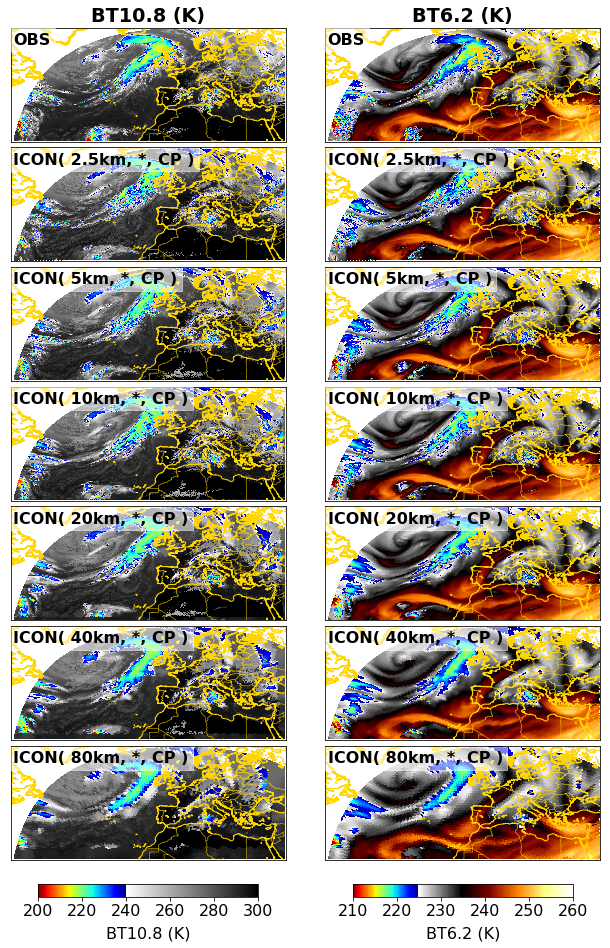

In [13]:
fig, axs = pl.subplots( nrows = 7, ncols = 2, figsize = (11,17), sharex = True, sharey = True )

labs = ['Meteosat', 'ICON 2.5km', 'ICON 5km', 'ICON 10km', 'ICON 20km', 'ICON 40km', 'ICON 80km']
labs = ['OBS', 
        'ICON( 2.5km, *, CP )', 'ICON( 5km, *, CP )', 
        'ICON( 10km, *, CP )',  'ICON( 20km, *, CP )',
        'ICON( 40km, *, CP )',  'ICON( 80km, *, CP )']
 
for i, basename in enumerate( sorted_fnames ):
        
    
    pl.sca( axs[i, 0] )
    mp = nawdex_analysis.plot.nawdex_map.nawdex_bt_plot( b108stack[basename], vname = 'bt108', plot_colorbar = False )
    
    pl.sca( axs[i, 1] )
    mp = nawdex_analysis.plot.nawdex_map.nawdex_bt_plot( b062stack[basename], vname = 'bt062', plot_colorbar = False )

    for j in [0, 1]:
        axs[i,j].text(-64, 59, labs[i], va = 'bottom', ha = 'left', fontweight = 'bold' , 
                      bbox = dict(facecolor='white', edgecolor = 'white', alpha=0.5))

#    if i >= 0:
#        break
    
        
axs[0,0].set_title('BT10.8 (K)', fontweight = 'bold')
axs[0,1].set_title('BT6.2 (K)', fontweight = 'bold')

pl.subplots_adjust( hspace = 0.05, wspace = 0.05, bottom = 0.2)

clabs = [np.arange(200,320,20), np.arange(200,270,10)]
tlabs = ['BT10.8 (K)', 'BT6.2 (K)']

for i in range(2):
    apos = axs[-1, i ].get_position()
    cax = fig.add_axes([apos.x0 + 0.05, apos.y0 - 0.03, apos.width - 0.1, 0.01])
    cbar = pl.colorbar(axs[-1, i].collections[-1], cax, orientation = 'horizontal', ticks = clabs[i], )
    pl.figtext(apos.x0 + apos.width / 2, apos.y0 - 0.06, tlabs[i], ha = 'center', va = 'center')


pl.savefig('../pics/01-BTs-overview.png')

### Matrix Plot for BT10.8

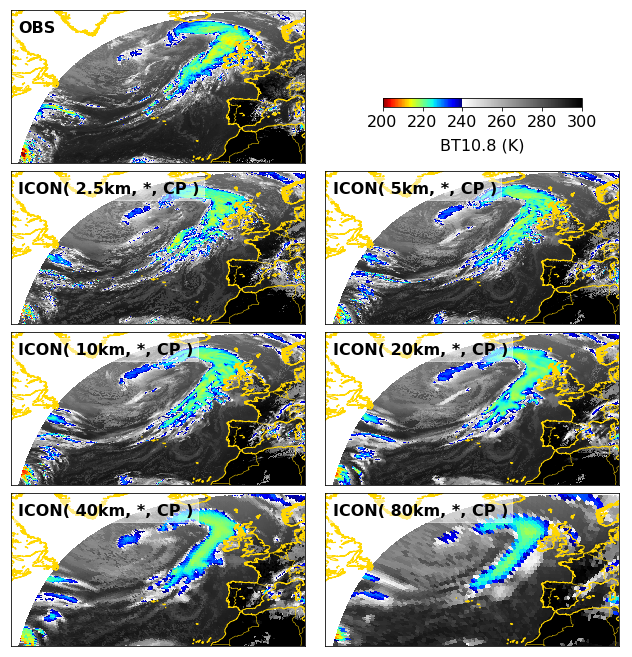

In [14]:
fig, axs = pl.subplots( nrows = 4, ncols = 2, figsize = (11, 13), sharex = True, sharey = True )
axs = axs.flatten()

labs = ['OBS', 
        'ICON( 2.5km, *, CP )', 'ICON( 5km, *, CP )', 
        'ICON( 10km, *, CP )',  'ICON( 20km, *, CP )',
        'ICON( 40km, *, CP )',  'ICON( 80km, *, CP )']




for i, basename in enumerate( sorted_fnames ):
        
    if i > 0:
        j = i + 1
    else:
        j = i
    a = axs[j]
    pl.sca( a )
    
    mp = nawdex_analysis.plot.nawdex_map.nawdex_bt_plot( b108stack[basename], vname = 'bt108', plot_colorbar = False )
    
    a.text(-63, 60, labs[i], va = 'bottom', ha = 'left', fontweight = 'bold' , 
                          bbox = dict(facecolor='white', edgecolor = 'white', alpha=0.5))
    
    if i == 1:
        a = axs[i]
        a.axis('off')
        #a.clear()
        apos = a.get_position()
        cax = fig.add_axes([apos.x0 + 0.05, apos.y0 + 0.06, apos.width - 0.1, 0.01])
        
        #        pl.sca( a )
#        pl.cla( )
        pcm = axs[0].collections[-1]

        cbar = pl.colorbar( pcm,  cax, orientation = 'horizontal', ticks= np.arange(200,320,20),)
        pl.figtext(apos.x0 + apos.width / 2, apos.y0 + 0.02, 'BT10.8 (K)', ha = 'center', va = 'center')

    xlim, ylim = ((-65, 10.802031483325052), (27.0, 66.5))
    a.set_xlim( xlim )
    a.set_ylim( ylim )
   

pl.subplots_adjust( hspace = 0.05, wspace = 0.05, bottom = 0.2)


pl.savefig('../pics/01-BT108-overview-m.png')

### Matrix Plot for BT6.2

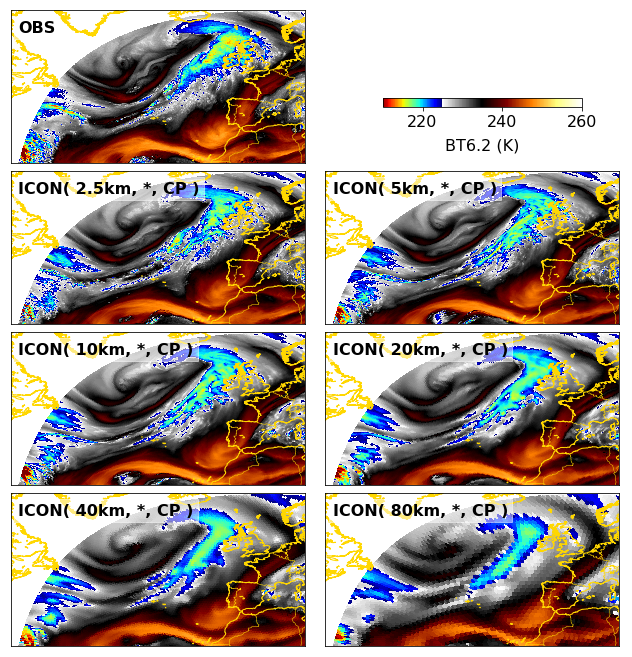

In [16]:
fig, axs = pl.subplots( nrows = 4, ncols = 2, figsize = (11, 13), sharex = True, sharey = True )
axs = axs.flatten()

labs = ['OBS', 
        'ICON( 2.5km, *, CP )', 'ICON( 5km, *, CP )', 
        'ICON( 10km, *, CP )',  'ICON( 20km, *, CP )',
        'ICON( 40km, *, CP )',  'ICON( 80km, *, CP )']




for i, basename in enumerate( sorted_fnames ):
        
    if i > 0:
        j = i + 1
    else:
        j = i
    a = axs[j]
    pl.sca( a )
    
    mp = nawdex_analysis.plot.nawdex_map.nawdex_bt_plot( b062stack[basename], vname = 'bt062', plot_colorbar = False )
    
    a.text(-63, 60, labs[i], va = 'bottom', ha = 'left', fontweight = 'bold' , 
                          bbox = dict(facecolor='white', edgecolor = 'white', alpha=0.5))
    
    if i == 1:
        a = axs[i]
        a.axis('off')
        #a.clear()
        apos = a.get_position()
        cax = fig.add_axes([apos.x0 + 0.05, apos.y0 + 0.06, apos.width - 0.1, 0.01])
        
        #        pl.sca( a )
#        pl.cla( )
        pcm = axs[0].collections[-1]

        cbar = pl.colorbar( pcm,  cax, orientation = 'horizontal', ticks= np.arange(200,320,20),)
        pl.figtext(apos.x0 + apos.width / 2, apos.y0 + 0.02, 'BT6.2 (K)', ha = 'center', va = 'center')

    xlim, ylim = ((-65, 10.802031483325052), (27.0, 66.5))
    a.set_xlim( xlim )
    a.set_ylim( ylim )
   
        

pl.subplots_adjust( hspace = 0.05, wspace = 0.05, bottom = 0.2)


pl.savefig('../pics/BT062-overview-m.png')